In [52]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

In [53]:
ratingCols = ['UserID','MovieID','Rating','Timestamp']
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', engine='python',header=None,names=ratingCols)
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [54]:
userCols = ['UserID','Gender','Age','Occupation','Zip-code']
users = pd.read_csv('ml-1m/users.dat', sep='::', engine='python',header=None,names=userCols)
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [55]:
movieCols = ['MovieID','Title','Genres']
movies = pd.read_csv('ml-1m/movies.dat', sep='::', engine='python',header=None,names=movieCols)
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [56]:
#Starting the process to remove the lesser known movies to remove noise
merge_movie_ratings = pd.merge(ratings,movies,on='MovieID')
drop_extra_columns = ['Timestamp','Genres']
merge_movie_ratings = merge_movie_ratings.drop(drop_extra_columns,axis=1)
merge_movie_ratings.head()

,UserID,MovieID,Rating,Title
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975)
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975)
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975)
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975)
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975)


In [57]:
merge_movie_ratings = merge_movie_ratings.dropna(axis = 0, subset=['Title'])

In [58]:
movie_ratingCount = (merge_movie_ratings.groupby(by = ['Title'])['Rating'].count().reset_index())
movie_ratingCount.head()

,Title,Rating
0,"$1,000,000 Duck (1971)",37
1,'Night Mother (1986),70
2,'Til There Was You (1997),52
3,"'burbs, The (1989)",303
4,...And Justice for All (1979),199


In [59]:
#Now Renaming the columns in movie_ratingCount
#movie_ratingCount = movie_ratingCount.rename(columns={'Title':'Rating'})[['movieTitle','totalRating']]
movie_ratingCount.columns = ['Title','totalRating']
movie_ratingCount.head()

,Title,totalRating
0,"$1,000,000 Duck (1971)",37
1,'Night Mother (1986),70
2,'Til There Was You (1997),52
3,"'burbs, The (1989)",303
4,...And Justice for All (1979),199


In [60]:
rating_with_totalRating = merge_movie_ratings.merge(movie_ratingCount,left_on='Title',right_on='Title',how='left')
rating_with_totalRating.head()

,UserID,MovieID,Rating,Title,totalRating
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),1725
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975),1725
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975),1725
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975),1725
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975),1725


In [61]:
#print(rating_with_totalRating)

In [62]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(movie_ratingCount['totalRating'].describe())

count   3706.000
mean     269.889
std      384.048
min        1.000
25%       33.000
50%      123.500
75%      350.000
max     3428.000
Name: totalRating, dtype: float64


In [63]:
print(movie_ratingCount['totalRating'].quantile(np.arange(.9,1,.01)))

0.900    729.500
0.910    773.550
0.920    825.000
0.930    887.300
0.940    971.400
0.950   1051.500
0.960   1133.800
0.970   1268.100
0.980   1446.600
0.990   1784.900
Name: totalRating, dtype: float64


In [64]:
threshold = 100
rating_popular_movie = movie_ratingCount.query('totalRating >= @threshold')
print(rating_popular_movie)

                                                 Title  totalRating
3                                   'burbs, The (1989)          303
4                        ...And Justice for All (1979)          199
6                    10 Things I Hate About You (1999)          700
7                                101 Dalmatians (1961)          565
8                                101 Dalmatians (1996)          364
9                                  12 Angry Men (1957)          616
10                            13th Warrior, The (1999)          750
12                         2 Days in the Valley (1996)          286
13                                     20 Dates (1998)          139
14                 20,000 Leagues Under the Sea (1954)          575
15                               200 Cigarettes (1999)          181
16                        2001: A Space Odyssey (1968)         1716
17                                         2010 (1984)          470
20                                      28 Days 

In [65]:
rating_with_totalRating_pivot = rating_with_totalRating.pivot(index='Title',columns='UserID',values='Rating').fillna(0)
rating_with_totalRating_matrix = csr_matrix(rating_with_totalRating_pivot.values)

In [66]:
#print(rating_with_totalRating_matrix)

In [67]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine',algorithm = 'brute')
model_knn.fit(rating_with_totalRating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [103]:
from PIL import Image
import matplotlib.pyplot as plt
from tmdbv3api import TMDb, Movie
from imageio import imread
tmdb = TMDb()
tmdb.api_key = 'f85a92e0b3635a045d81d26e262c119d'
tmdb.language = 'en'
tmdb.debug = True
m = Movie()
prefix = 'https://image.tmdb.org/t/p/w200/'


def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [102]:
query_index = np.random.choice(rating_with_totalRating_pivot.shape[0])
distances, indices = model_knn.kneighbors(rating_with_totalRating_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)
L = []
s = ""
results = []
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(rating_with_totalRating_pivot.index[query_index]))
        s = rating_with_totalRating_pivot.index[indices.flatten()[i]]
        results = m.search(s[:-6]) 
        suffix = results[0].poster_path
        url = prefix + suffix
        L.append(url)
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, rating_with_totalRating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
        s = rating_with_totalRating_pivot.index[indices.flatten()[i]]
        results = m.search(s[:-6]) 
        suffix = results[0].poster_path
        url = prefix + suffix
        L.append(url)

Recommendations for Brassed Off (1996):



INFO:tmdbv3api.tmdb:{'page': 1, 'total_results': 1, 'total_pages': 1, 'results': [{'vote_count': 127, 'id': 9450, 'video': False, 'vote_average': 7.1, 'title': 'Brassed Off', 'popularity': 5.974, 'poster_path': '/wX1ryXNwcyKUwAFIKqRAYhFDfKL.jpg', 'original_language': 'en', 'original_title': 'Brassed Off', 'genre_ids': [35, 10749, 18], 'backdrop_path': '/85tRmUvCpVpbucZzblt1jwSn391.jpg', 'adult': False, 'overview': 'A small Yorkshire mining town is threatened with being shut down and the only hope is for the men to enter their Grimley Colliery Brass Band into a national competition. They believe they have no hope until Gloria appears carrying her Flugelhorn. At first mocked for being a woman, she soon becomes the only chance for the band to win.', 'release_date': '1996-11-01'}]}


1: Four Weddings and a Funeral (1994), with distance of 0.6866691956683921:


INFO:tmdbv3api.tmdb:{'page': 1, 'total_results': 1, 'total_pages': 1, 'results': [{'vote_count': 1293, 'id': 712, 'video': False, 'vote_average': 6.7, 'title': 'Four Weddings and a Funeral', 'popularity': 11.537, 'poster_path': '/md9kMKnLG8LG4pMDM98gy5x4K5L.jpg', 'original_language': 'en', 'original_title': 'Four Weddings and a Funeral', 'genre_ids': [35, 18, 10749], 'backdrop_path': '/wyvHy4ElaiNamrpS6fjquYQqxhQ.jpg', 'adult': False, 'overview': 'Charles and Carrie go through numerous weddings in order to determine if they are right for one another.', 'release_date': '1994-03-09'}]}


2: Muriel's Wedding (1994), with distance of 0.6926118048525738:


INFO:tmdbv3api.tmdb:{'page': 1, 'total_results': 1, 'total_pages': 1, 'results': [{'vote_count': 181, 'id': 236, 'video': False, 'vote_average': 7.1, 'title': "Muriel's Wedding", 'popularity': 6.912, 'poster_path': '/zJyTr8Fo412a2OIfJGXTRAm4IwX.jpg', 'original_language': 'en', 'original_title': "Muriel's Wedding", 'genre_ids': [18, 35, 10749], 'backdrop_path': '/9P3g2ECZFuSICHdAtxk0hLb8cPI.jpg', 'adult': False, 'overview': 'A young social outcast in Australia steals money from her parents to finance a vacation where she hopes to find happiness, and perhaps love.', 'release_date': '1994-08-22'}]}


3: Full Monty, The (1997), with distance of 0.7068201865793786:


INFO:tmdbv3api.tmdb:{'page': 1, 'total_results': 1, 'total_pages': 1, 'results': [{'vote_count': 796, 'id': 9427, 'video': False, 'vote_average': 7, 'title': 'The Full Monty', 'popularity': 8.331, 'poster_path': '/xkMiZv2FPrhIAtxvEcN1jAbkHRY.jpg', 'original_language': 'en', 'original_title': 'The Full Monty', 'genre_ids': [35], 'backdrop_path': '/mAaSPfGA4ixiKSXYydNpbwZswi6.jpg', 'adult': False, 'overview': 'Sheffield, England. Gaz, a jobless steelworker in need of quick cash persuades his mates to bare it all in a one-night-only strip show.', 'release_date': '1997-08-13'}]}


4: Shine (1996), with distance of 0.7102851146914086:


INFO:tmdbv3api.tmdb:{'page': 1, 'total_results': 124, 'total_pages': 7, 'results': [{'vote_count': 286, 'id': 7863, 'video': False, 'vote_average': 7.4, 'title': 'Shine', 'popularity': 7.987, 'poster_path': '/yjcdr2YadLwnoyUrRxNzcHVptAq.jpg', 'original_language': 'en', 'original_title': 'Shine', 'genre_ids': [18], 'backdrop_path': '/mLNn3ajWEk1RQGXVD4YfbySCf1T.jpg', 'adult': False, 'overview': 'Pianist David Helfgott, driven by his father and teachers, has a breakdown. Years later he returns to the piano, to popular if not critical acclaim.', 'release_date': '1996-08-15'}, {'vote_count': 57, 'id': 385737, 'video': False, 'vote_average': 5.6, 'title': 'Always Shine', 'popularity': 4.969, 'poster_path': '/fLrFpga7qDf68lqvyGTpCYuaP4G.jpg', 'original_language': 'en', 'original_title': 'Always Shine', 'genre_ids': [53], 'backdrop_path': '/pA8UG22VlPyxyuy3Z3jzEWBHg0h.jpg', 'adult': False, 'overview': "On a trip to Big Sur, two friends, both actresses, try to reconnect with one another. Once 

5: Peter's Friends (1992), with distance of 0.7108903460887269:


INFO:tmdbv3api.tmdb:{'page': 1, 'total_results': 1, 'total_pages': 1, 'results': [{'vote_count': 73, 'id': 11790, 'video': False, 'vote_average': 6.8, 'title': "Peter's Friends", 'popularity': 5.348, 'poster_path': '/rmtLaQCQihbKIsuriek8qbjWbSu.jpg', 'original_language': 'en', 'original_title': "Peter's Friends", 'genre_ids': [35, 18], 'backdrop_path': '/jzKm77hlqTQeq7Dl3EgUer6NUet.jpg', 'adult': False, 'overview': "It is New Year's weekend and the friends of Peter (Fry) gather at his newly inherited country house. Ten years ago, they all acted together in a Cambridge University student comedy troupe, but it's less clear how much they have in common now.Peter's friends are Andrew (Branagh), now a writer in Hollywood; married jingle writers Roger (Laurie) and Mary (Staunton); glamorous costume designer Sarah (Emmanuel); and eccentric Maggie (Thompson), who works in publishing. Cast in sharp relief to the university chums are Carol (Rudner), the American TV star wife of Andrew; and louti

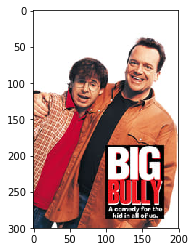

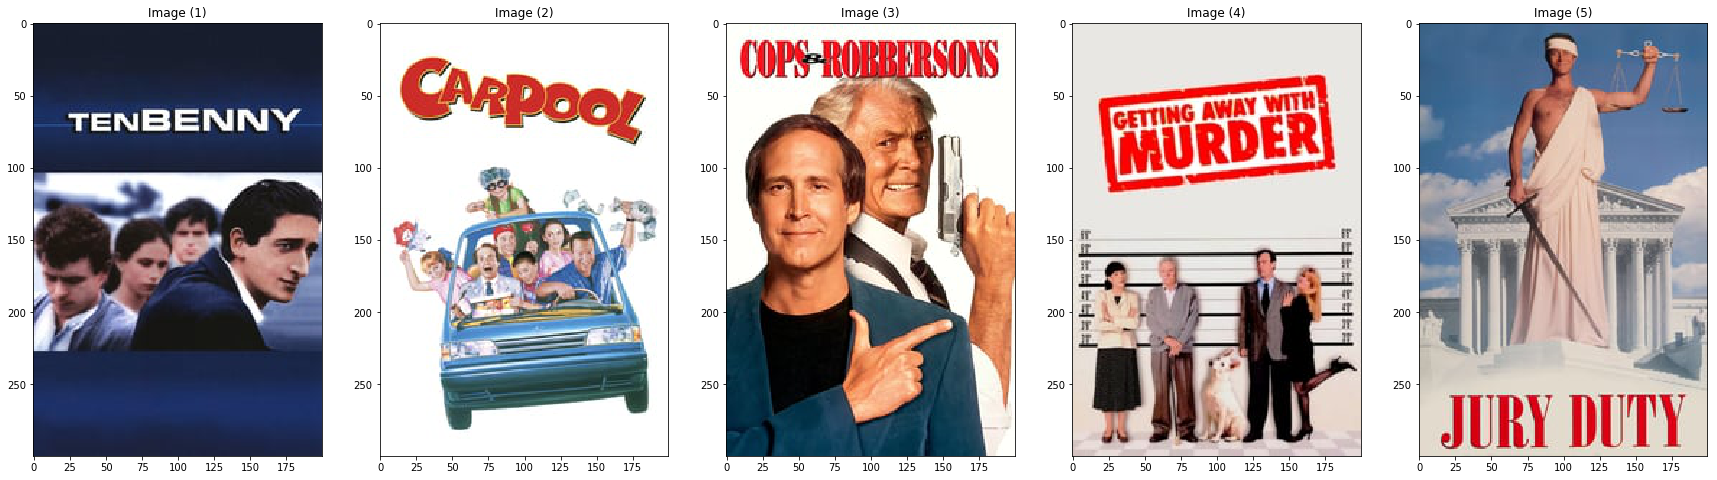

In [100]:
ImgList = []
for i in range(6):
    image = imread(L[i])
    ImgList.append(image)
plt.imshow(ImgList[0])

show_images(ImgList[1:]);    
# for i in range(6):    
#     poster = Image.fromarray(ImgList[i])
# fig = plt.imshow(poster)    